
反復学習: イテレーション 1/4

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |   1.00ms ( 12.20us) 438.00us (  5.34us)        82
       nlp_g  |        0 (       0) 271.00us (  3.30us)        82
  nlp_grad_f  |   2.00ms ( 25.32us) 597.00us (  7.56us)        79
  nlp_hess_l  |   1.00ms ( 12.99us)   1.12ms ( 14.52us)        77
   nlp_jac_g  |        0 (       0) 674.00us (  8.53us)        79
       total  |  68.00ms ( 68.00ms)  65.03ms ( 65.03ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 113.00us (  4.52us)        25


 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:166: RuntimeWarning:overflow encountered in divide
 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:137: RuntimeWarning:overflow encountered in square
 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:138: RuntimeWarning:invalid value encountered in add


GPR: 学習完了

反復学習: イテレーション 2/4
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  76.00us (  4.47us)        17
       nlp_g  |        0 (       0)  59.00us (  3.47us)        17
  nlp_grad_f  |        0 (       0) 130.00us (  7.22us)        18
  nlp_hess_l  |        0 (       0) 218.00us ( 13.62us)        16
   nlp_jac_g  |   1.00ms ( 55.56us) 167.00us (  9.28us)        18
       total  |  12.00ms ( 12.00ms)  11.67ms ( 11.67ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  78.00us (  4.59us)        17
       nlp_g  |        0 (       0)  57.00us (  3.35us)        17
  nlp_grad_f  |   1.00ms ( 55.56us) 136.00us (  7.56us)        18
  nlp_hess_l  |        0 (       0) 226.00us ( 14.12us)        16
   nlp_jac_g  |        0 (       0) 156.00us (  8.67us)        18
       total  |  11.00ms ( 11.00ms)  11.93ms ( 11.93ms)         1
      solver  :   t_proc      (avg)   t_wall   

 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\rbf.py:178: RuntimeWarning:invalid value encountered in multiply
 c:\Users\sakurai\abc\Lib\site-packages\GPy\kern\src\stationary.py:243: RuntimeWarning:invalid value encountered in divide


GPR: 学習完了

反復学習: イテレーション 3/4
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0) 108.00us (  4.70us)        23
       nlp_g  |        0 (       0)  86.00us (  3.74us)        23
  nlp_grad_f  |        0 (       0) 176.00us (  7.33us)        24
  nlp_hess_l  |        0 (       0) 310.00us ( 14.09us)        22
   nlp_jac_g  |        0 (       0) 218.00us (  9.08us)        24
       total  |  16.00ms ( 16.00ms)  17.26ms ( 17.26ms)         1
      solver  :   t_proc      (avg)   t_wall      (avg)    n_eval
       nlp_f  |        0 (       0)  87.00us (  5.12us)        17
       nlp_g  |        0 (       0)  80.00us (  4.71us)        17
  nlp_grad_f  |        0 (       0) 132.00us (  7.33us)        18
  nlp_hess_l  |        0 (       0) 236.00us ( 14.75us)        16
   nlp_jac_g  |        0 (       0) 160.00us (  8.89us)        18
       total  |  11.00ms ( 11.00ms)  12.76ms ( 12.76ms)         1
      solver  :   t_proc      (avg)   t_wall   

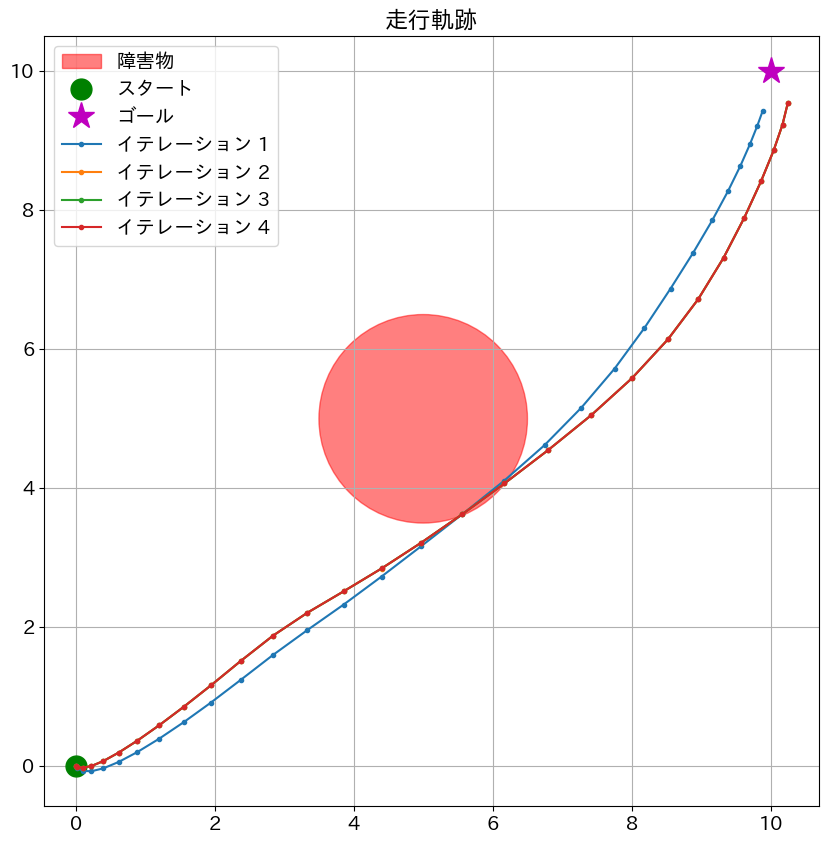

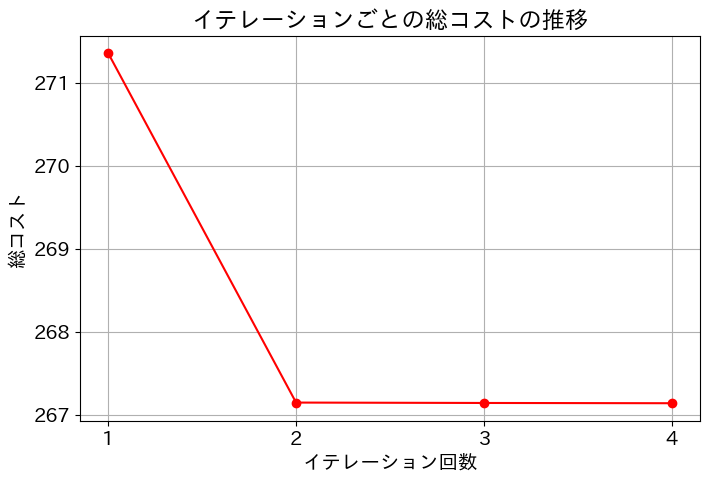

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import GPy
import casadi as ca
import time

# Matplotlibの日本語設定とスタイル設定
import japanize_matplotlib
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.figsize'] = (8, 8)

# ==================================================================================
# シミュレーション全体の設定パラメータ
# ==================================================================================
N_ITERATIONS = 4
SIM_STEPS = 100
DT = 0.1
NX, NU = 4, 2
START_STATE = np.array([0.0, 0.0, 0.0, 0.0])
GOAL_STATE = np.array([10.0, 10.0])
N_MPC = 20
OBSTACLE_INFO = {'pos': np.array([5.0, 5.0]), 'rad': 1.5}

# ==================================================================================
# SafeSet クラス
# ==================================================================================
class SafeSet:
    """過去の軌跡データから安全集合とコスト・トゥ・ゴーを管理するクラス"""
    def __init__(self):
        # (状態, コスト・トゥ・ゴー) のタプルを格納するリスト
        self.database = []
        self.is_initialized = False

    def add_trajectory(self, trajectory_data):
        """1回のイテレーションデータをデータベースに追加する"""
        costs_to_go = []
        running_cost = 0
        # 軌跡の最後から逆算して、各状態からのコスト・トゥ・ゴーを計算
        for state, stage_cost in reversed(trajectory_data):
            running_cost += stage_cost
            self.database.append((state, running_cost))
        
        if self.database:
            self.is_initialized = True

    def get_best_point_and_cost(self):
        """データベースから最も優秀な点（コスト最小）とそのコストを返す"""
        if not self.is_initialized:
            # データがない場合は、ゴール地点を目標とし、コストはゼロと仮定
            return GOAL_STATE, 0.0
        
        # データベース内でコストが最小のタプルを見つける
        best_point, min_cost = min(self.database, key=lambda item: item[1])
        return best_point[:2], min_cost # 位置情報とコストのみ返す


# ----------------------------------------------------------------------------------
# 真のシステム
# ----------------------------------------------------------------------------------
class TrueVehicle:
    def __init__(self, dt=0.1):
        self.dt = dt
    def dynamics(self, x, u):
        px, py, vx, vy = x; ax, ay = u
        # GPRが学習すべき、モデル化されていない非線形項
        drag = 0.1
        vx_next = vx + (ax - drag * vx**2) * self.dt
        vy_next = vy + (ay - drag * vy**2) * self.dt
        px_next = px + vx * self.dt + 0.5 * ax * self.dt**2
        py_next = py + vy * self.dt + 0.5 * ay * self.dt**2
        return np.array([px_next, py_next, vx_next, vy_next])

# ----------------------------------------------------------------------------------
# ガウス過程回帰モデル (ダイナミクス学習)
# ----------------------------------------------------------------------------------
class GPRModel:
    def __init__(self, nx, nu, dt, obstacle_info):
        self.nx, self.nu = nx, nu
        self.dt=DT
        self.obstacle_info=OBSTACLE_INFO
        self.is_trained = False
        self.X_data = np.empty((0, self.nx + self.nu))
        self.Y_data = np.empty((0, self.nx))
        self.models = [None] * self.nx

    def add_data(self, x, u, x_next):
        # nominal モデルからの誤差（デルタ）を学習ターゲットにする
        delta_real = (x_next - x) / self.dt
        delta_nominal = np.array([x[2], x[3], u[0], u[1]])
        error = delta_real - delta_nominal
        self.X_data = np.vstack([self.X_data, np.hstack([x, u])])
        self.Y_data = np.vstack([self.Y_data, error])

    def train(self):
        if len(self.X_data) < 10: return
        print("GPR: 学習開始...")
        for i in range(self.nx):
            kernel = GPy.kern.RBF(input_dim=self.nx + self.nu, ARD=True)
            model = GPy.models.GPRegression(self.X_data, self.Y_data[:, i:i+1], kernel)
            model.optimize(messages=False, max_iters=100)
            self.models[i] = model
        self.is_trained = True
        print("GPR: 学習完了")

    def predict(self, x, u):
        if not self.is_trained:
            return np.zeros(self.nx)
        xu = np.hstack([x, u]).reshape(1, -1)
        means = np.array([m.predict(xu)[0][0, 0] if m else 0 for m in self.models])
        return means

# ----------------------------------------------------------------------------------
# Component 3: MPCコントローラ
# ----------------------------------------------------------------------------------
class MPCController:
    def __init__(self, nx, nu, N, dt, obstacle_info):
        self.nx, self.nu, self.N, self.dt = nx, nu, N, dt
        self.obstacle_info = obstacle_info
        self.u_prev_sol = np.zeros((nu, N))

    def solve(self, x_current, gpr_model, x_goal, safe_set):
        opti = ca.Opti()
        U = opti.variable(self.nu, self.N)
        X = opti.variable(self.nx, self.N + 1)
        
        cost = 0
        opti.subject_to(X[:, 0] == x_current)

        error_mean = gpr_model.predict(x_current, np.zeros(self.nu))
        
        for k in range(self.N):
            x_k, u_k = X[:, k], U[:, k]
            delta_nominal = ca.vertcat(x_k[2], x_k[3], u_k[0], u_k[1])
            delta_pred = delta_nominal + error_mean
            x_next_pred = x_k + delta_pred * self.dt
            opti.subject_to(X[:, k+1] == x_next_pred)

            cost += ca.sumsqr(x_k[:2] - x_goal) * self.dt
            cost += ca.sumsqr(u_k) * self.dt * 0.01
            if self.obstacle_info is not None:
                dist_to_obs = ca.norm_2(x_k[:2] - self.obstacle_info['pos'])
                # 障害物半径の内側に入った分だけ、2乗に比例したペナルティを課す
                penalty = ca.fmax(0, self.obstacle_info['rad'] - dist_to_obs)
                cost += 500.0 * penalty**2
        
         # 1. 安全集合から最も良い点とそのコストを取得
        best_target_pos, best_cost = safe_set.get_best_point_and_cost()
        
        # 2. そのコストを基準に、終端コストを定義
        terminal_state = X[:, self.N]
        # (過去の最小コスト) + (その最小コストを達成した地点からの距離ペナルティ)
        cost += best_cost + ca.sumsqr(terminal_state[:2] - best_target_pos) * 10.0
        #cost += ca.sumsqr(X[:2, self.N] - x_goal) * 20.0

        opti.minimize(cost)
        opti.subject_to(opti.bounded(-5.0, U, 5.0))

        opti.set_initial(X, np.tile(x_current, (self.N + 1, 1)).T)
        opti.set_initial(U, self.u_prev_sol)
        
        s_opts = {'print_level': 0}
        opti.solver('ipopt', {}, s_opts)

        try:
            sol = opti.solve()
            self.u_prev_sol = np.hstack((sol.value(U)[:, 1:], sol.value(U)[:, -1].reshape(-1, 1)))
            return sol.value(U[:, 0])
        except Exception as e:
            print(f"MPC: 最適化失敗。x={x_current}, error: {e}")
            return np.zeros(self.nu)

# ----------------------------------------------------------------------------------
# Main Simulation Loop
# ----------------------------------------------------------------------------------
def main():
    vehicle = TrueVehicle(dt=DT)
    gpr_model = GPRModel(nx=NX, nu=NU, dt=DT, obstacle_info=OBSTACLE_INFO)
    mpc = MPCController(nx=NX, nu=NU, N=N_MPC, dt=DT, obstacle_info=OBSTACLE_INFO)

    safe_set = SafeSet()
    all_trajectories, final_costs = [], []

    for i in range(N_ITERATIONS):
        print(f"\n{'='*50}\n反復学習: イテレーション {i+1}/{N_ITERATIONS}\n{'='*50}")
        current_x = np.copy(START_STATE)
        total_cost = 0
        iteration_data_for_gpr = []
        iteration_data_for_safeset=[]

        for step in range(SIM_STEPS):
            u_optimal = mpc.solve(current_x, gpr_model, GOAL_STATE, safe_set)
            x_next = vehicle.dynamics(current_x, u_optimal)
            
            stage_cost = (np.sum((current_x[:2] - GOAL_STATE)**2) + np.sum(u_optimal**2) * 0.01) * DT
            total_cost += stage_cost
            iteration_data_for_gpr.append((current_x, u_optimal, x_next))
            iteration_data_for_safeset.append((current_x,stage_cost))
            current_x = x_next

            if np.linalg.norm(current_x[:2] - GOAL_STATE) < 0.5:
                print(f"ステップ {step+1} でゴールに到達！")
                break
        
        all_trajectories.append(np.array([d[0] for d in iteration_data_for_safeset]))
        final_costs.append(total_cost)
        print(f"イテレーション {i+1} の総コスト: {total_cost:.2f}")

        for x, u, x_n in iteration_data_for_gpr:
            gpr_model.add_data(x, u, x_n)
        gpr_model.train()

        safe_set.add_trajectory(iteration_data_for_safeset)

    # --- 結果の可視化 ---
    plt.figure(figsize=(10, 10))
    if OBSTACLE_INFO is not None:
        obs_circle = plt.Circle(OBSTACLE_INFO['pos'], OBSTACLE_INFO['rad'], color='r', alpha=0.5, label='障害物')
        plt.gca().add_patch(obs_circle)
    plt.plot(START_STATE[0], START_STATE[1], 'go', markersize=15, label='スタート')
    plt.plot(GOAL_STATE[0], GOAL_STATE[1], 'm*', markersize=20, label='ゴール')
    for i, traj in enumerate(all_trajectories):
        plt.plot(traj[:, 0], traj[:, 1], '-o', markersize=3, label=f'イテレーション {i+1}')
    plt.title('走行軌跡')
    plt.legend()
    plt.axis('equal')
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(range(1, N_ITERATIONS + 1), final_costs, '-ro')
    plt.title('イテレーションごとの総コストの推移')
    plt.xlabel('イテレーション回数')
    plt.ylabel('総コスト')
    plt.xticks(range(1, N_ITERATIONS + 1))
    plt.show()

if __name__ == '__main__':
    main()